In [1]:
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from pandas import DataFrame
import xlsxwriter

ct_sheet = pd.ExcelFile("Training Data.xlsx") 

Using TensorFlow backend.


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(290, 148)
(290, 148)
Tensor("input_1:0", shape=(None, 148), dtype=float32)
Epoch 1/150
290/290 [==============================] - 3s 9ms/step - loss: 0.2564
Epoch 2/150
290/290 [==============================] - 0s 1ms/step - loss: 0.1551
Epoch 3/150
290/290 [==============================] - 0s 1ms/step - loss: 0.1441
Epoch 4/150
290/290 [==============================] - 0s 671us/step - loss: 0.1397
Epoch 5/150
290/290 [==============================] - 0s 796us/step - loss: 0.1382
Epoch 6/150
290/290 [==============================] - 0s 689us/step - loss: 0.1346
Epoch 7/150
290/290 [==============================] - 0s 1ms/step - loss: 0.1328
Epoch 8/150
290/290 [==============================] - 0s 1ms/step - loss: 0.1322
Epoch 9/150
290/290 [==============================] - 0s 783us/step - loss: 0.1325
Epoch 10/150
290/290 [==============================] - 0s 666us/step - loss: 0.1309
Epoch 11/150
290/290 [==============================] - 0s 866us/step - loss: 0.1314
Epoch 12

290/290 [==============================] - 0s 864us/step - loss: 0.1055
Epoch 97/150
290/290 [==============================] - 0s 789us/step - loss: 0.1040
Epoch 98/150
290/290 [==============================] - 0s 729us/step - loss: 0.1041
Epoch 99/150
290/290 [==============================] - 0s 760us/step - loss: 0.1042
Epoch 100/150
290/290 [==============================] - 0s 725us/step - loss: 0.1040
Epoch 101/150
290/290 [==============================] - 0s 1ms/step - loss: 0.1036
Epoch 102/150
290/290 [==============================] - 0s 893us/step - loss: 0.1039
Epoch 103/150
290/290 [==============================] - 0s 1ms/step - loss: 0.1043
Epoch 104/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1035
Epoch 105/150
290/290 [==============================] - 0s 1ms/step - loss: 0.1047
Epoch 106/150
290/290 [==============================] - 0s 2ms/step - loss: 0.1048
Epoch 107/150
290/290 [==============================] - 0s 1ms/step - loss: 0.10

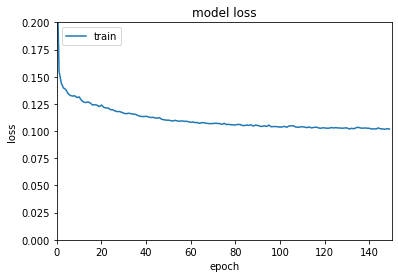

In [2]:
parsee = ct_sheet.sheet_names[2]
data = ct_sheet.parse(parsee)
data_features = data.loc[:, data.columns] 
data_features = data_features.drop(['ROI',11142,12142], axis=1)  

parsee2 = ct_sheet.sheet_names[3]
data2 = ct_sheet.parse(parsee2)
data_labels = data2.loc[:, data2.columns] 
data_labels = data_labels.drop(['ROI',11142,12142], axis=1)  
#Get rid of subject names to only have features now. #Need to remove ROIs. They don't convert to floats.
#Get rid of ctx_rh_Medial_wall and ctx_lh_Medial_wall, not needed for analysis.
#Have to standardize data. Scikit learn here. Need to create stratified K folds to avoid uneven distribution of risk groups.pcaCT1Y = PCA(n_components=150) #150 Features
scaler_filename = "IBIS_scaledSA1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y = scaler.transform(data_features)

scaler_filename2 = "IBIS_scaledSA2y.save"
scaler2 = joblib.load(scaler_filename2)
scaled_data_2y = scaler.transform(data_labels)
print(scaled_data_1y.shape)
print(scaled_data_2y.shape)
#X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, scaled_labels, test_size=0.10, random_state=20)

#Size of encoded representation
#{'batch_size': 10, 'dropout': 0.15, 'encoded_layer_size': 25, 'epochs': 150, 'layer1_size': 100, 'layer2_size': 40}
input_size = 148
hidden_size = 100
hidden_size_2 = 40
encoding_dim = 25
dropout = 0.15

# Input Placeholder
input_data = Input(shape=(input_size,))
print(input_data)
# "encoded" is the encoded representation of the input
hidden_e_1 = Dense(hidden_size, activation='tanh')(input_data) 
hidden_e_2 = Dense(hidden_size_2, activation='tanh')(hidden_e_1)
dropout_layer = Dropout(dropout)(hidden_e_2)
encoded = Dense(encoding_dim, activation='tanh')(dropout_layer)
# "decoded" is the lossy reconstruction of the input
hidden_d_1 = Dense(hidden_size, activation='tanh')(encoded)
dropout_layer_d = Dropout(dropout)(hidden_d_1)
hidden_d_2 = Dense(hidden_size, activation='tanh')(dropout_layer_d)
decoded = Dense(input_size, activation='tanh')(hidden_d_2) 
# this model maps an input to its prediction
autoencoder = Model(input_data, decoded)
# configure our model to use mean_absolute_error loss function, and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='mean_absolute_error')

ac = autoencoder.fit(scaled_data_1y, scaled_data_2y,
epochs=150,
batch_size=10,
shuffle=True)

#print(ac.history.keys())
# "Loss"
plt.plot(ac.history['loss'])
#plt.plot(ac.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.axis([0, 150, 0.0, 0.2])
plt.show()

In [3]:
autoencoder.save("Autoencoder Input 1 year Output 2 year SA")

In [4]:
sa_sheet_1y = pd.ExcelFile("Data to be Interpolated.xlsx") 
parsee = sa_sheet_1y.sheet_names[3]
print(parsee)
data = sa_sheet_1y.parse(parsee)
data_features_sa1y = data.loc[:, data.columns] 
data_features_sa1y = data_features_sa1y.drop(['ROI',11142,12142], axis=1)
scaled_data_sa1y = scaler.transform(data_features_sa1y)
print(scaled_data_sa1y.shape)

predicted_2yr_sa = autoencoder.predict(scaled_data_sa1y)

1Y SA
(36, 148)


In [5]:
print(predicted_2yr_sa)

[[0.5788271  0.5571292  0.5229578  ... 0.41332155 0.7616789  0.42533752]
 [0.498013   0.625526   0.5352229  ... 0.28626928 0.6912963  0.40401134]
 [0.39702615 0.434815   0.39165846 ... 0.46591577 0.6632968  0.31633875]
 ...
 [0.5332984  0.6683318  0.40272072 ... 0.56831557 0.6700869  0.34497413]
 [0.5840901  0.46975046 0.509726   ... 0.594262   0.695524   0.3997544 ]
 [0.6090349  0.6232231  0.36131772 ... 0.5771413  0.58769345 0.3617891 ]]


In [6]:
df = pd.DataFrame(predicted_2yr_sa)
df.to_excel("Interpolated SA 2y.xlsx", index=False)

In [7]:
df

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0.578827,0.557129,0.522958,0.477770,0.579161,0.791450,0.439103,0.642805,0.524798,0.348635,...,0.683787,0.773794,0.614773,0.470487,0.327525,0.388288,0.616242,0.413322,0.761679,0.425338
1,0.498013,0.625526,0.535223,0.489746,0.354035,0.682195,0.677081,0.435882,0.596734,0.388904,...,0.708136,0.618470,0.439100,0.384915,0.356055,0.627726,0.747368,0.286269,0.691296,0.404011
2,0.397026,0.434815,0.391658,0.425496,0.518873,0.832366,0.540142,0.674203,0.526580,0.355145,...,0.677005,0.785826,0.539467,0.490816,0.294081,0.284243,0.360927,0.465916,0.663297,0.316339
3,0.525460,0.569618,0.483714,0.523586,0.373174,0.707615,0.757680,0.514921,0.579688,0.290638,...,0.760296,0.555582,0.567175,0.268846,0.349186,0.696319,0.730875,0.680926,0.642443,0.509625
4,0.420167,0.423154,0.394459,0.256408,0.327746,0.495667,0.417092,0.443824,0.290068,0.238687,...,0.601054,0.453509,0.325570,0.240665,0.209788,0.330814,0.327143,0.285576,0.509775,0.348343
5,0.669482,0.475246,0.472682,0.408270,0.464829,0.606239,0.487089,0.442533,0.463532,0.431444,...,0.748701,0.551779,0.543362,0.324941,0.298738,0.476187,0.743529,0.448250,0.751588,0.472327
6,0.458963,0.454621,0.361523,0.390045,0.453445,0.679361,0.621155,0.396800,0.423686,0.290446,...,0.589306,0.690429,0.542101,0.368711,0.312479,0.467967,0.526911,0.384306,0.620642,0.292192
7,0.694649,0.586720,0.461609,0.435199,0.513654,0.750917,0.507042,0.638793,0.487702,0.318144,...,0.730652,0.602989,0.484358,0.399860,0.319423,0.533404,0.621485,0.552412,0.655898,0.416556
8,0.624042,0.596650,0.439938,0.576441,0.498690,0.759223,0.651614,0.579182,0.570166,0.426973,...,0.849234,0.716751,0.562789,0.464903,0.302754,0.503895,0.628387,0.527615,0.691941,0.322702
9,0.614981,0.531379,0.535777,0.587406,0.367488,0.674481,0.678632,0.610878,0.608950,0.365237,...,0.803535,0.696609,0.457735,0.244171,0.298484,0.582382,0.620304,0.470346,0.746355,0.393614


In [8]:
#Now calculate MAE on the original Gilmore Dataset
gilmore_sheet = pd.ExcelFile("Gilmore CT1y2y SA1y2y.xlsx") 
parsee = gilmore_sheet.sheet_names[1] #sa1y
print(parsee)
data = gilmore_sheet.parse(parsee)
data_features_sa1y = data.loc[:, data.columns] 
data_features_sa1y = data_features_sa1y.drop(['ROI'], axis=1)
scaled_data_sa1y_gilmore = scaler.transform(data_features_sa1y)
print(scaled_data_sa1y_gilmore.shape)

predicted_2yr_sa_gilmore = autoencoder.predict(scaled_data_sa1y_gilmore)
df = pd.DataFrame(predicted_2yr_sa_gilmore)
df.to_excel("Interpolated SA 2y Gilmore Scaled.xlsx", index=False)

SA1y
(247, 148)


In [9]:
#Inverse Transform the predicted data to calculate MAE
unscaled_predicted_sa2y = scaler2.inverse_transform(predicted_2yr_sa_gilmore)
type(unscaled_predicted_sa2y)
df = pd.DataFrame(unscaled_predicted_sa2y)
df.to_excel("Interpolated SA 2y Gilmore.xlsx", index=False)